<left><img src="https://github.com/infocusp/scaLR/raw/sj/fullntest_samples_analysis/img/scaLR_logo.png" width="150" height="180"></left>

# Single-cell analysis using Low Resource (scaLR)

## <span style="color: steelblue;">Cloning scaLR</span>

In [1]:
!git clone -b sj/fullntest_samples_analysis https://github.com/infocusp/scaLR.git

Cloning into 'scaLR'...
remote: Enumerating objects: 3093, done.
remote: Counting objects: 100% (661/661), done.
remote: Compressing objects: 100% (271/271), done.
remote: Total 3093 (delta 391), reused 616 (delta 369), pack-reused 2432 (from 1)
Receiving objects: 100% (3093/3093), 166.83 MiB | 10.75 MiB/s, done.
Resolving deltas: 100% (1840/1840), done.


In [2]:
!pip install -r scaLR/requirements_10_m.txt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 5.9 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=d260a73ff6c8c751a94fb30b822f0036fb647b199574ade42a9c1d8bca689896
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


## <span style="color: steelblue;">Downloading input anndata from `cellxgene`</span>
- Currently the pipeline expects all datasets in [anndata](https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html) formats (`.h5ad` files only).
- The anndata object should contain cell samples as `obs` and genes as `var`.
- `adata.X`: contains normalized gene counts/expression values (Typically `log1p` normalized, data ranging from 0-10).
- `adata.obs`: contains any metadata regarding cells, including a column for `target` which will be used for classification. The index of `adata.obs` is cell_barcodes.
- `adata.var`: contains all gene_names as Index.

The dataset we are about to download contains two clinical conditions (COVID-19 and normal) and links variations in immune response to disease severity and outcomes over time[(Liu et al. (2021))](https://doi.org/10.1016/j.cell.2021.02.018)

In [3]:
# This shell will take approximately 00:00:53 (hh:mm:ss) to run.
import time
!wget -P data https://datasets.cellxgene.cziscience.com/21ef2ea2-cbed-4b6c-a572-0ddd1d9020bc.h5ad

--2024-10-23 08:37:10--  https://datasets.cellxgene.cziscience.com/21ef2ea2-cbed-4b6c-a572-0ddd1d9020bc.h5ad
Resolving datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)... 18.160.200.37, 18.160.200.93, 18.160.200.112, ...
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|18.160.200.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 980103606 (935M) [binary/octet-stream]
Saving to: ‘data/21ef2ea2-cbed-4b6c-a572-0ddd1d9020bc.h5ad’

21ef2ea2-cbed-4b6c- 100%[===================>] 934.70M  18.3MB/s    in 53s     

2024-10-23 08:38:04 (17.7 MB/s) - ‘data/21ef2ea2-cbed-4b6c-a572-0ddd1d9020bc.h5ad’ saved [980103606/980103606]



## <span style="color: steelblue;">Data exploration</span>

In [4]:
import warnings
import anndata as ad
from anndata import AnnData
import numpy as np
import pandas as pd

In [5]:
adata = ad.read_h5ad("data/21ef2ea2-cbed-4b6c-a572-0ddd1d9020bc.h5ad",backed='r')

In [6]:
print(f"\nThe anndata has '{adata.n_obs}' cells and '{adata.n_vars}' genes")


The anndata has '125117' cells and '30695' genes


In [7]:
# Cell metadata
adata.obs.head()

,dsm_severity_score_group,disease_ontology_term_id,severity,tissue_ontology_term_id,timepoint,outcome,dsm_severity_score,days_since_hospitalized,age,donor_id,...,tissue_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
AAACCTGAGAAACCTA-1_1,DSM_low,MONDO:0100096,Moderate,UBERON:0000178,T0,alive,-1.950858,1.0,55.0,HGR0000083,...,tissue,non-classical monocyte,10x 5' v1,COVID-19,Homo sapiens,male,blood,European,55-year-old stage,!9L}G4hgnw
AAACCTGAGGGTTTCT-1_1,DSM_high,MONDO:0100096,Critical,UBERON:0000178,T0,alive,-0.092375,13.0,40.0,HGR0000078,...,tissue,classical monocyte,10x 5' v1,COVID-19,Homo sapiens,female,blood,European,40-year-old stage,YRcUzlVyg0
AAACCTGCACCTGGTG-1_1,DSM_high,MONDO:0100096,Critical,UBERON:0000178,T0,alive,2.954350,1.0,60.0,HGR0000098,...,tissue,"CD16-positive, CD56-dim natural killer cell, h...",10x 5' v1,COVID-19,Homo sapiens,male,blood,European,60-year-old stage,)*azge@M0l
AAACCTGGTCCGAGTC-1_1,DSM_high,MONDO:0100096,Critical,UBERON:0000178,T0,deceased,3.276233,6.0,76.0,HGR0000141,...,tissue,classical monocyte,10x 5' v1,COVID-19,Homo sapiens,male,blood,European,76-year-old stage,E<FU`+QN&T
AAACCTGGTGCCTTGG-1_1,DSM_low,MONDO:0100096,Critical,UBERON:0000178,T0,alive,-0.348888,1.0,70.0,HGR0000093,...,tissue,classical monocyte,10x 5' v1,COVID-19,Homo sapiens,male,blood,European,70-year-old stage,2MZ#6SX}{g


In [8]:
adata.obs.cell_type.value_counts()

,count
cell_type,
classical monocyte,78908
"CD16-positive, CD56-dim natural killer cell, human",28705
non-classical monocyte,6160
natural killer cell,3825
platelet,3370
"CD16-negative, CD56-bright natural killer cell, human",1237
conventional dendritic cell,991
plasmacytoid dendritic cell,787
granulocyte,776


In [9]:
# Number of cell types
adata.obs.cell_type.unique()

['non-classical monocyte', 'classical monocyte', 'CD16-positive, CD56-dim natural killer cell, ..., 'natural killer cell', 'plasmacytoid dendritic cell', 'conventional dendritic cell', 'platelet', 'CD16-negative, CD56-bright natural killer cel..., 'granulocyte', 'intermediate monocyte']
Categories (10, object): ['granulocyte', 'platelet', 'natural killer cell',
                          'plasmacytoid dendritic cell', ..., 'CD16-negative, CD56-bright natural killer cel...,
                          'CD16-positive, CD56-dim natural killer cell, ..., 'conventional dendritic cell', 'intermediate monocyte']

In [10]:
# Number of donors
adata.obs.donor_id.unique()

['HGR0000083', 'HGR0000078', 'HGR0000098', 'HGR0000141', 'HGR0000093', ..., 'SHD3', 'HGR0000101', 'HGR0000135', 'SHD5', 'SHD6']
Length: 46
Categories (46, object): ['AA220014', 'AA220534', 'AA220907', 'HDML', ..., 'SHD4', 'SHD5', 'SHD6', 'SHD7']

In [11]:
# Number of clinical conditions
adata.obs.disease.value_counts()

,count
disease,
COVID-19,99152
normal,25965


In [12]:
#Gene expression values of first 5 cells and 10 genes.
adata.X[:5,:10].A

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.99008936, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

In [13]:
# Verifying normalized values in X
# Getting the sum of gene expression values for the first 10 cells (should be floating-point values).
adata.X[:10,:].A.sum(axis=1)

array([2264.9421, 2374.6707, 2097.2356, 2345.2798, 2542.3647, 2362.8406,
       2241.9297, 1986.2373, 2578.1968, 2652.637 ], dtype=float32)

In [14]:
# Getting the maximum and minimum gene expression values for the first 1000 cells.
max_val = np.max(adata.X[:1000, :].A)
min_val = np.min(adata.X[:1000, :].A)
print(f'Max value : {max_val} | Min value : {min_val}')
# Raising a warning if the values are outside the 0-10 range
if max_val > 10 or min_val < 0:
    warnings.warn(f"Warning: Expression Value out of range! Max: {max_val}, Min: {min_val}. Expected range is 0-10.", UserWarning)


Max value : 8.524538040161133 | Min value : 0.0


In [16]:
#Gene metadata
adata.var.head()

,mvp.mean,mvp.dispersion,mvp.dispersion.scaled,mvp.variable,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type
ENSG00000168454,0.000380,1.168876,0.181734,False,False,TXNDC2,NCBITaxon:9606,gene,1703,protein_coding
ENSG00000197852,0.035995,1.634179,0.886458,False,False,INKA2,NCBITaxon:9606,gene,1217,protein_coding
ENSG00000196878,0.008862,1.617729,0.861545,False,False,LAMB3,NCBITaxon:9606,gene,3931,protein_coding
ENSG00000256540,0.000022,1.660993,0.927070,False,False,IQSEC3-AS1,NCBITaxon:9606,gene,1065,lncRNA
ENSG00000139180,0.090100,1.184720,0.205731,False,False,NDUFA9,NCBITaxon:9606,gene,782,protein_coding


### <span style="color: steelblue;">Modifying `var` index (Optional)</span>
- The `index` values in this AnnData object are the `gene_ids`. To retrieve the literature genes associated with a particular cell type, we need the gene symbols, which are present in `feature_name`. Therefore, we'll replace the index values with gene symbols.
- This will be helpful when analyzing the `GeneRecallCurve` later.
- This step can be skipped if the `reference_genes.csv` already contains gene IDs corresponding to each cell type, or if the user does not want to perform the `GeneRecallCurve` analysis.


In [17]:
adata.var.set_index('feature_name',inplace=True)

In [18]:
# Now the index values are the gene symbols.
adata.var.head()

,mvp.mean,mvp.dispersion,mvp.dispersion.scaled,mvp.variable,feature_is_filtered,feature_reference,feature_biotype,feature_length,feature_type
feature_name,,,,,,,,,
TXNDC2,0.000380,1.168876,0.181734,False,False,NCBITaxon:9606,gene,1703,protein_coding
INKA2,0.035995,1.634179,0.886458,False,False,NCBITaxon:9606,gene,1217,protein_coding
LAMB3,0.008862,1.617729,0.861545,False,False,NCBITaxon:9606,gene,3931,protein_coding
IQSEC3-AS1,0.000022,1.660993,0.927070,False,False,NCBITaxon:9606,gene,1065,lncRNA
NDUFA9,0.090100,1.184720,0.205731,False,False,NCBITaxon:9606,gene,782,protein_coding


In [19]:
#Saving file for further analysis
# This shell will take approximately 00:00:47 (hh:mm:ss) to run.
adata.obs.index = adata.obs.index.astype(str)
adata.var.index = adata.var.index.astype(str)
AnnData(X=adata.X,obs=adata.obs,var=adata.var).write('data/modified_adata.h5ad',compression='gzip')

## <span style="color: steelblue;">scaLR pipeline </span>

1. The **scaLR** pipeline consists of four stages:
   - Data ingestion
   - Feature selection
   - Final model training
   - Analysis

2. The user needs to modify the configuration file (`config.yml`) available at `scaLR/config` for each stage of the pipeline according to the requirements. Simply omit or comment out the stages of the pipeline that you do not wish to run.

3. Refer to `config.yml` and its detailed configuration [README](https://github.com/infocusp/scaLR/blob/main/config/README.md) file for instructions on how to use different parameters and files.

### <span style="color: steelblue;">Config edits (For Cell Type Classification and Biomarker Identification)</span>
- **Device setup**.
  -Update `device: 'cuda'` for `GPU` enabled runtype, else `device: 'cpu'` for `CPU` enabled  runtype.
- **Experiment Config**
  - The default `exp_run` number is `0`.If not changed, the celltype classification experiment would be `exp_run_0` with all the pipeline results.
- **Data Config**
  - Update the `full_datapath` to `data/modified_adata.h5ad` (as we will include `GeneRecallCurve` in the downstream).
  - Set `target` to `cell_type`.
- **Feature Selection**
  - Update the model layers to `[5000, 10]`, as there are only 10 cell types in the dataset.
  - Change `epoch` to `10`.
- **Final Model Training**
  - Update the model layers to the same as for feature selection: `[5000, 10]`.
  - Change `epoch` to `100`.
- **Analysis**
  - **Downstream Analysis**
    - Uncomment the `test_samples_downstream_analysis` section.
    - Update the `reference_genes_path` to `scaLR/tutorials/pipeline/grc_reference_gene.csv`.
    - Please refer to the section below:
    ```
    analysis:

        model_checkpoint: ''

        dataloader:
            name: SimpleDataLoader
            params:
                batch_size: 15000

        gene_analysis:
            scoring_config:
                name: LinearScorer

            features_selector:
                name: ClasswisePromoters
                params:
                    k: 100
        test_samples_downstream_analysis:
            - name: GeneRecallCurve
              params:
                reference_genes_path: 'scaLR/tutorials/pipeline/grc_reference_gene.csv'
                top_K: 300
                plots_per_row: 3
                features_selector:
                    name: ClasswiseAbs
                    params: {}
            - name: Heatmap
              params: {}
            - name: RocAucCurve
              params: {}

### <span style="color: steelblue;">Config edits (For clinical condition specific biomarker identification and DGE analysis) </span>
- **Experiment Config**
  - Make sure to change the `exp_run` number if you have an experiment with the same number earlier related to cell classification.As we have done one experiment earlier, we'll change the number now to '1'.
- **Data Config**
  - The `full_datapath` remains the same as above.
  - Change the `target` to `disease` (this column contains data for clinical conditions, `COVID-19/normal`).
- **Feature Selection**
  - Update the model layers to `[5000, 2]`, as there are only two types of clinical conditions.
  -`epoch` as 10.
- **Final Model Training**
  - Update the model layers to the same as for feature selection: `[5000, 2]`.
  - `epoch` as 100.
- **Analysis**
  - **Downstream Analysis**
    - Uncomment the `full_samples_downstream_analysis` section.
    - We are not performing the 'gene_recall_curve' analysis in this case. It can be performed if the `COVID-19/normal` specific genes are available, but there are many possibilities of genes in the case of normal conditions.
    - There are two options to perform differential gene expression (DGE) analysis: `DgePseudoBulk` and `DgeLMEM`. The parameters are updated as follows. Note that `DgeLMEM` may take a bit more time, as the multiprocessing is not very efficient with only 2 CPUs in the current Colab runtime.
    - Please refer to the section below:
    ```
    analysis:

        model_checkpoint: ''

        dataloader:
            name: SimpleDataLoader
            params:
                batch_size: 15000

        gene_analysis:
            scoring_config:
                name: LinearScorer

            features_selector:
                name: ClasswisePromoters
                params:
                    k: 100
        full_samples_downstream_analysis:
            - name: Heatmap
              params:
                top_n_genes: 100
            - name: RocAucCurve
              params: {}
            - name: DgePseudoBulk
              params:
                  celltype_column: 'cell_type'
                  design_factor: 'disease'
                  factor_categories: ['COVID-19', 'normal']
                  sum_column: 'donor_id'
                  cell_subsets: ['conventional dendritic cell', 'natural killer cell']
            - name: DgeLMEM
              params:
                fixed_effect_column: 'disease'
                fixed_effect_factors: ['COVID-19', 'normal']
                group: 'donor_id'
                celltype_column: 'cell_type'
                cell_subsets: ['conventional dendritic cell']
                gene_batch_size: 1000
                coef_threshold: 0.1


### <span style="color: steelblue;">Run Pipeline </span>
Pipeline logs can be found at `/scalr_experiments/exp_name_{exp_run}/logs.txt`

In [20]:
# Possible flags using 'scaLR/pipeline.py'
!python scaLR/pipeline.py --help

2024-10-23 08:44:54.997089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 08:44:55.034077: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 08:44:55.045178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 08:44:55.078046: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 08:44:56.931093: W tensorflow/compiler/tf2

In [23]:
# Command to run end to end pipeline.
# This shell will take approximately 00:21:15 (hh:mm:ss) on GPU to run.(Cell Type Classification)
!python scaLR/pipeline.py --config scaLR/config/config.yaml -l -m

#It takes 01:16:58 (hh:mm:ss) to run on the CPU for clinical condition-specific biomarker identification.
#To reduce the runtime, please comment out the 'DgeLMEM' section under the 'full_samples_downstream_analysis.

2024-10-23 08:57:43.515506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 08:57:43.552179: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 08:57:43.563122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 08:57:43.589711: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 08:57:46.283238: W tensorflow/compiler/tf2

### <span style="color: steelblue;">Results </span>
We have done the celltype classification and biomarker discovery with name `exp_name_0`.
- The  classification report can be found at `scalr_experiments/exp_name_0/analysis/classification_report.csv`
- Top-5k Biomarkers can be found at `scalr_experiments/exp_name_0/analysis/gene_analysis/top_features.json`.
- Feature importance scores for biomarkers can be found at `scalr_experiments/exp_name_0/analysis/gene_analysis/score_matrix.csv`
- `Heatmaps` for each class(cell types) can be found at `scalr_experiments/exp_name_0/analysis/test_samples/heatmaps`
- `Gene_recall_curve`, and `roc_auc` data can be found at `scalr_experiments/exp_name_0/analysis/test_samples/`.

In [ ]:
#Classification report
pd.read_csv('/content/scalr_experiments/exp_name_0/analysis/classification_report.csv')

,Unnamed: 0,precision,recall,f1-score,support
0,"CD16-negative, CD56-bright natural killer cell...",0.842520,0.769784,0.804511,278.000000
1,"CD16-positive, CD56-dim natural killer cell, h...",0.907656,0.953702,0.930110,6091.000000
2,classical monocyte,0.980512,0.993094,0.986763,22444.000000
3,conventional dendritic cell,0.870229,0.570000,0.688822,200.000000
4,granulocyte,0.256000,0.410256,0.315271,78.000000
5,intermediate monocyte,0.000000,0.000000,0.000000,118.000000
6,natural killer cell,0.550085,0.390361,0.456660,830.000000
7,non-classical monocyte,0.941381,0.887794,0.913803,1827.000000
8,plasmacytoid dendritic cell,0.903114,0.973881,0.937163,268.000000
9,platelet,0.938567,0.835020,0.883771,988.000000


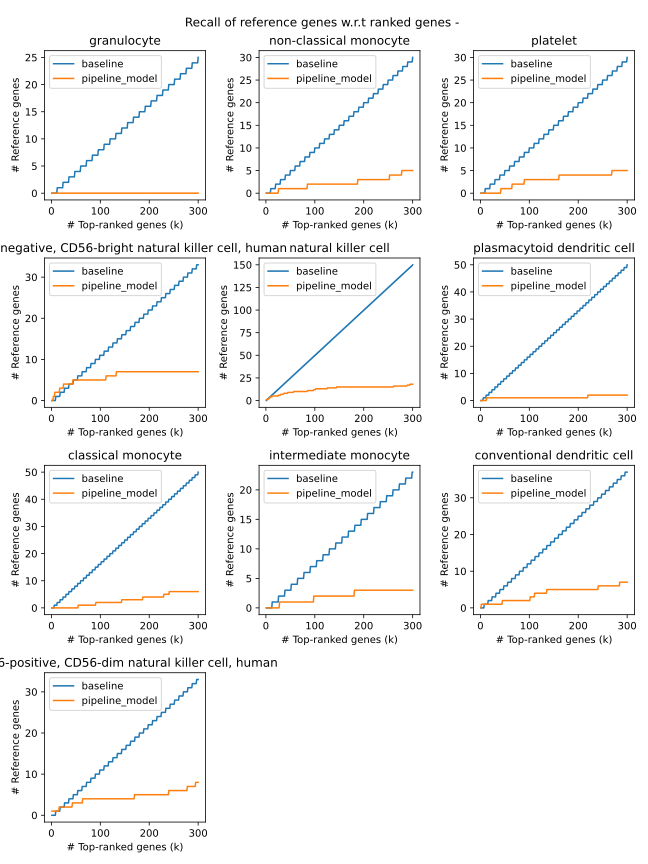

In [ ]:
# Gene recall curve
display(SVG('scalr_experiments/exp_name_0/analysis/test_samples/gene_recall_curve.svg'))

We have done the clinical condition specific biomarker identification and DGE analysis the experiment name as 'exp_name_1'.



## <span style="color: steelblue;">Running scaLR in modules</span>

### Imports

In [27]:
import sys
# sys.path.insert(0, '..')
sys.path.append('scaLR/')
import os
from os import path

from scalr.data_ingestion_pipeline import DataIngestionPipeline
from scalr.eval_and_analysis_pipeline import EvalAndAnalysisPipeline
from scalr.feature_extraction_pipeline import FeatureExtractionPipeline
from scalr.model_training_pipeline import ModelTrainingPipeline
from scalr.utils import read_data
from scalr.utils import write_data

### Load Config

In [28]:
#Modify the 'config.yaml' as per the above config edits.
config = read_data('scaLR/config/config.yaml')
config

{'device': 'cpu',
 'experiment': {'dirpath': 'scalr_experiments',
  'exp_name': 'exp_name',
  'exp_run': 2},
 'data': {'sample_chunksize': 20000,
  'train_val_test': {'full_datapath': 'data/modified_adata.h5ad',
   'splitter_config': {'name': 'GroupSplitter',
    'params': {'split_ratio': [7, 1, 2.5], 'stratify': 'donor_id'}}},
  'target': 'cell_type'},
 'feature_selection': {'feature_subsetsize': 5000,
  'model': {'name': 'SequentialModel',
   'params': {'layers': [5000, 10], 'weights_init_zero': True}},
  'model_train_config': {'trainer': 'SimpleModelTrainer',
   'dataloader': {'name': 'SimpleDataLoader',
    'params': {'batch_size': 25000, 'padding': 5000}},
   'optimizer': {'name': 'SGD', 'params': {'lr': 0.001, 'weight_decay': 0.1}},
   'loss': {'name': 'CrossEntropyLoss'},
   'epochs': 10},
  'scoring_config': {'name': 'LinearScorer'},
  'features_selector': {'name': 'AbsMean', 'params': {'k': 5000}}},
 'final_training': {'model': {'name': 'SequentialModel',
   'params': {'layers

In [30]:
dirpath = config['experiment']['dirpath']
exp_name = config['experiment']['exp_name']
exp_run = config['experiment']['exp_run']
dirpath = os.path.join(dirpath, f'{exp_name}_{exp_run}')
os.makedirs(dirpath, exist_ok=True)
device = config['device']

### Data Ingestion

In [ ]:
import time
start_time = time.time()
data_dirpath = path.join(dirpath, 'data')
os.makedirs(data_dirpath, exist_ok=True)

# Initialize Data Ingestion object
ingest_data = DataIngestionPipeline(config['data'], data_dirpath)

# Generate Train, Validation and Test Splits for pipeline
ingest_data.generate_train_val_test_split()

# Apply pre-processing on data
# Fit on Train data, and then apply on the entire data
ingest_data.preprocess_data()

# We generate label mapings from the metadata, which is used for
# labels, etc.
ingest_data.generate_mappings()

# All the additional data generated (label mappings, data splits, etc.)
# are passed onto the config for future use in pipeline
config['data'] = ingest_data.get_updated_config()
write_data(config, path.join(dirpath, 'config.yaml'))
del ingest_data

### Feature Selection

In [ ]:
feature_extraction_dirpath = path.join(dirpath, 'feature_extraction')
os.makedirs(feature_extraction_dirpath, exist_ok=True)

# Initialize Feature Extraction object
extract_features = FeatureExtractionPipeline(
    config['feature_selection'], feature_extraction_dirpath, device)
extract_features.load_data_and_targets_from_config(config['data'])

# Train feature subset models and get scores for each feature/genes
extract_features.feature_subsetted_model_training()
extract_features.feature_scoring()

# Extract top features by some algorithm, and write a feature-subsetted
# dataset
extract_features.top_feature_extraction()
config['data'] = extract_features.write_top_features_subset_data(
    config['data'])

# All the additional data generated (subset data splits, etc.)
# are passed onto the config for future use in pipeline
config['feature_selection'] = extract_features.get_updated_config()
write_data(config, path.join(dirpath, 'config.yaml'))
del extract_features

### Final Model Training

In [ ]:
model_training_dirpath = path.join(dirpath, 'model')
os.makedirs(model_training_dirpath, exist_ok=True)

# Initialize Final Model Training object
model_trainer = ModelTrainingPipeline(
    config['final_training']['model'],
    config['final_training']['model_train_config'],
    model_training_dirpath, device)
model_trainer.load_data_and_targets_from_config(config['data'])

# Build the training artifacts from config, and train the model
model_trainer.build_model_training_artifacts()
model_trainer.train()

# All the additional data generated (model defaults filled, etc.)
# are passed onto the config for future use in pipeline
model_config, model_train_config = model_trainer.get_updated_config()
config['final_training']['model'] = model_config
config['final_training']['model_train_config'] = model_train_config
write_data(config, path.join(dirpath, 'config.yaml'))
del model_trainer

### Evaluation and Analysis

In [ ]:
analysis_dirpath = path.join(dirpath, 'analysis')
os.makedirs(analysis_dirpath, exist_ok=True)

# Get path of the best trained model
config['analysis']['model_checkpoint'] = path.join(
    model_training_dirpath, 'best_model')

# Initialize Evaluation and Analysis Pipeline object
analyser = EvalAndAnalysisPipeline(config['analysis'], analysis_dirpath,
                                    device)
analyser.load_data_and_targets_from_config(config['data'])

# Perform evaluation of trained model on test data and generate
# classification report
analyser.evaluation_and_classification_report()

# Perform gene analysis based on the trained model to get
# top genes / biomarker analysis
analyser.gene_analysis()

# Perform downstream analysis on all samples / test samples
analyser.full_samples_downstream_anlaysis()
analyser.test_samples_downstream_anlaysis()

# All the additional data generated
# are passed onto the config for future use in pipeline
config['analysis'] = analyser.get_updated_config()
write_data(config, path.join(dirpath, 'config.yaml'))
del analyser